In [1]:
%load_ext autoreload
%autoreload 2

# import matplotlib as mpl
# mpl.use('Agg')

from IPython.display import display
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import json

# from BackwardImplementation_fromPaper import prepare_training_data, backward_implementation_from_paper

import sys
sys.path.append('..')
from helper.orderbook_trader import OrderbookTradingSimulator
from helper.Q_learning import QLearn, round_custombase
from helper.manage_orderbooks_v2 import OrderbookEpisodesGenerator, plot_episode
from datetime import datetime

In [2]:
filename_train = '/home/axel/data/obs_2016-11_USDT_BTC_range1.2.dict'
filename_test = '/home/axel/data/obs_2016-12_USDT_BTC_range1.2.dict'

modelname = 'models/obs_2016-11_USDT_BTC_range1.2_ALLsamples.json'
# samples = 2
V = 100
vol_intervals = 10
T = 4
P = 15
actions = list(np.linspace(-0.4, 1.0, num=15))
print("V={}, T={}, P={}".format(V, T, P))
print("Actions: ", ", ".join(["{:1.2f}".format(a) for a in actions]))

V=100, T=4, P=15
Actions:  -0.40, -0.30, -0.20, -0.10, -0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.00


In [3]:
episodes_train = OrderbookEpisodesGenerator(filename=filename_train, episode_length=T*P)
print("Length of episodes_train: {}".format(len(episodes_train)))
# episode_windows_train = prepare_training_data(filename, samples=samples, T=T, P=P, first_line=0)

episodes_test = OrderbookEpisodesGenerator(filename=filename_test, episode_length=T*P)
print("Length of episodes_test: {}".format(len(episodes_test)))

Length of episodes_train: 541
Length of episodes_test: 743


/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


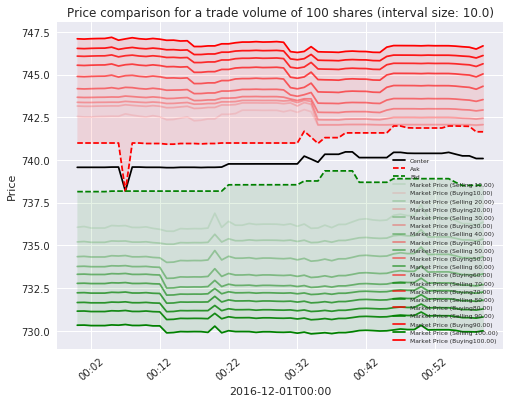

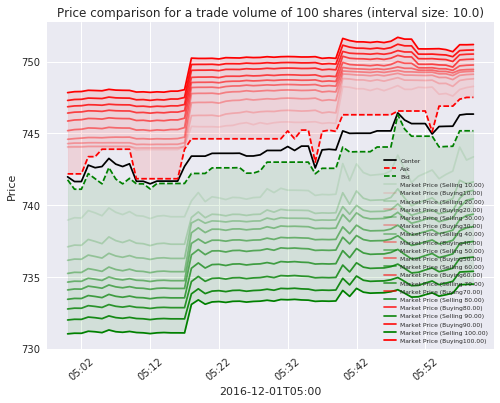

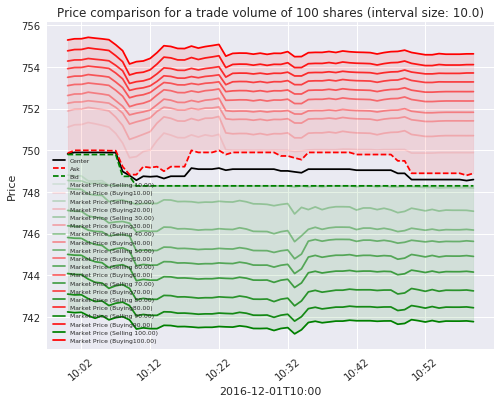

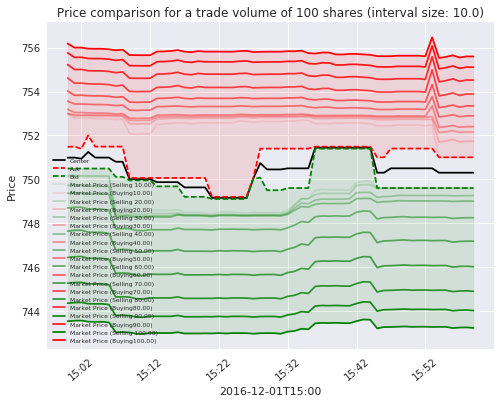

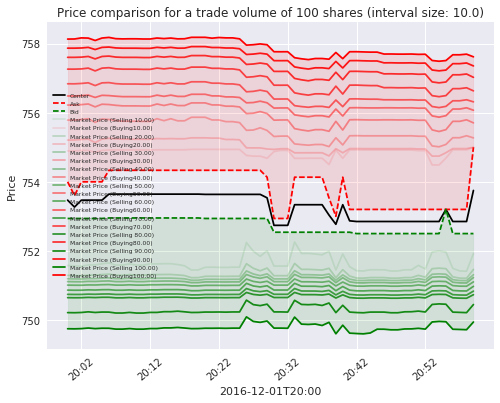

In [4]:
for e in range(5):
    plot_episode(episodes_test[e*5], volume=100, intervals=10) #, outfile='orderbook_window.pdf')

In [6]:
def optimal_strategy(traingdata, V, T, period_length, vol_intervals, actions, verbose=True, ql=None, modelname=None):
    timestamp = datetime.now()
    
    print("V: {}, T: {}, period_length: {}, vol_intervals: {}, num_actions: {}".format(V, T, period_length, vol_intervals, len(actions)))
    print("actions: {}".format(actions))
    volumes = np.linspace(1, 0, num=10+1)[:-1] # skip volumes=0
    
    volumes_base = float(V)/vol_intervals

    print("volumes: {}".format(volumes))
    
    ql = ql or QLearn(actions=actions, vol_intervals=vol_intervals, V=V, T=T, period_length=period_length)

    for tt in tqdm(range(T)[::-1]):
        trading_startpoint = period_length*tt
        time_left = T-tt

        for e, episode in tqdm(enumerate(traingdata)):
            initial_center = episode[0].get_center()
            
            center = episode[trading_startpoint].get_center()
            ask = episode[trading_startpoint].get_ask()
            
            for vol in volumes:
                if tt == 0 and vol != 1.:
                    # at t=0 we always have 100% of the volume left.
                    break
                
                for a in actions:
                    state = ql.state_as_string(time_left=time_left, volume_left=vol)  # , orderbook=episode[trading_startpoint])
                    
                    ots = OrderbookTradingSimulator(orderbooks=episode[trading_startpoint:], volume=vol*V, tradingperiods=T-tt,
                                                    period_length=period_length)
                    limit = ask * (1. + (a/100.))

                    ots.trade(limit = limit)  # agression_factor=a)

                    volume_left = ots.volume
                    volume_left_rounded = round_custombase(volume_left, base=volumes_base)

                    volume_traded = ots.history.volume_traded.values[-1]
                    volume_traded_rounded = round_custombase(volume_traded, base=volumes_base)

                    assert volume_left_rounded + volume_traded_rounded - vol*V <= 1.e-8, "{} {} {} {}".format(
                        volume_left_rounded, volume_traded_rounded, vol, V)

                    avg = ots.history.avg[-1]

                    # manually compute costs, since we have to think in discrete volume steps (rounding ...)
                    cost = volume_traded_rounded * (avg - initial_center) / initial_center
                    
                    new_state = ql.state_as_string(time_left=time_left-1, volume_left=volume_left_rounded/V)  #, orderbook=ots.masterbook)
                    
                    ql.learn(state, a, cost, new_state)
               
            # if e%5 == 0 or e==len(traingdata):
            #     ql.plot_Q(outfile="graphs/Q_function_{}_action".format(T-tt), epoch=e, outformat='pdf', z_represents='action', verbose=verbose)
            #     ql.plot_Q(outfile="graphs/Q_function_{}_Q".format(T-tt), epoch=e, outformat='pdf', z_represents='Q', verbose=verbose)
            #     modelname = modelname or "models/Q_function_{}".format(timestamp)
            #     ql.save(outfile=modelname)
                
            
    # plot_episode(episode, volume=V)
    return ql

In [7]:
print("test started")
ql = optimal_strategy(traingdata=episodes_train[:1], V=V, T=T, period_length=P,
                      vol_intervals=vol_intervals, actions=actions, modelname=modelname)

  0%|          | 0/4 [00:00<?, ?it/s]
0it [00:00, ?it/s]

test started
V: 100, T: 4, period_length: 15, vol_intervals: 10, num_actions: 15
actions: [-0.40000000000000002, -0.30000000000000004, -0.20000000000000004, -0.10000000000000003, -5.5511151231257827e-17, 0.099999999999999922, 0.19999999999999996, 0.29999999999999993, 0.39999999999999991, 0.49999999999999989, 0.59999999999999987, 0.69999999999999984, 0.79999999999999993, 0.8999999999999998, 1.0]
volumes: [ 1.   0.9  0.8  0.7  0.6  0.5  0.4  0.3  0.2  0.1]



1it [01:55, 115.18s/it]
 25%|██▌       | 1/4 [01:55<05:45, 115.19s/it]
0it [00:00, ?it/s]
1it [01:44, 104.21s/it]
 50%|█████     | 2/4 [03:39<03:43, 111.90s/it]
0it [00:00, ?it/s]
1it [01:38, 98.78s/it]
 75%|███████▌  | 3/4 [05:18<01:47, 107.96s/it]
0it [00:00, ?it/s]
1it [00:14, 14.90s/it]
100%|██████████| 4/4 [05:33<00:00, 80.04s/it] 


/home/axel/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


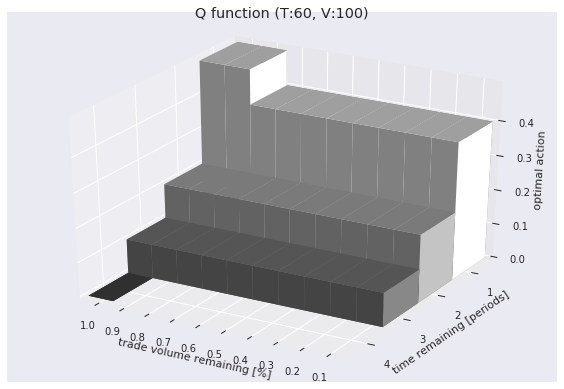

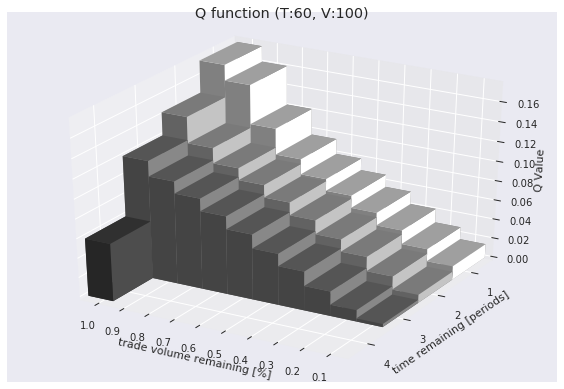

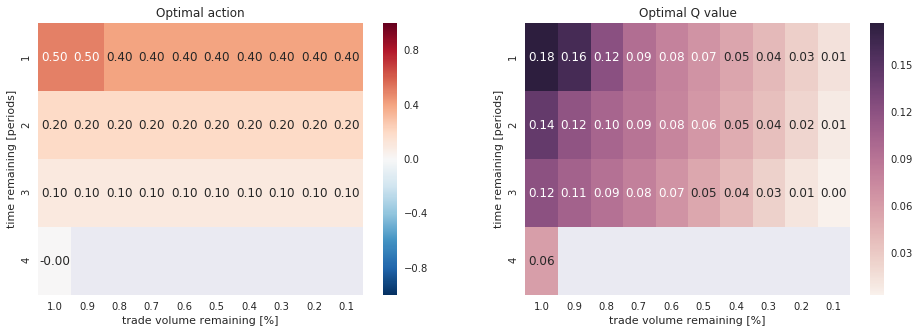

In [9]:
ql.plot_Q(z_represents='action')
ql.plot_Q(z_represents='Q')
ql.heatmap_Q()